In [49]:
# packages
import os, sys
import logging
import numpy as np
from torch.utils.data import Dataset
from collections import OrderedDict
import scipy.integrate as integrate

In [50]:
image_available = os.listdir("/home/yando/NAS01/Databank/1_Radiology/in_house/Lung/DCM_RP/")

In [51]:
#base_dir = "/home/yando/Workspace/DVH_FEATURE_EXTRACTOR/data/KNUCH_DVH_ANALYSIS_SH_PARK"
base_dir="/mnt/yando/Databank/1_Radiology/in_house/Lung/DVH_ID_FIX"
files = [file for file in os.listdir(base_dir) if file.split(".")[0] in image_available]
nfiles = [file for file in os.listdir(base_dir) if file.split(".")[0] not in image_available]
logging.basicConfig(level=logging.DEBUG)
# error in 7765, missing structure
#missing = ["7765.txt", "7689_7201070.txt"]
#_ = [files.pop(files.index(m)) for m in missing]

In [52]:
print(len(files), len(nfiles), nfiles)

340 12 ['1331.txt', '1455.txt', '1079.txt', '1320.txt', '1321.txt', '1386.txt', '1003.txt', '1304.txt', '1307.txt', '334.txt', '1312.txt', '1328.txt']


In [53]:
class DVHDataset(Dataset):
        def __init__(self, dose_files, label, dose_features=["mean_dose", "V_5", "V_10", "V_15", "V_20"], to_cumulative=True):
            super().__init__()
            self.dose_data = dose_files
            self.label = label
            self.dose_features = dose_features
            self.minmax = lambda x : x / 2000.0
            self.to_cumulative = to_cumulative

        def _get_dose(self, index):
            if self.dose_data is not None:
                if isinstance(self.dose_data[index], str):
                    self.dose_data[index] = self._parse_dose_file(self.dose_data[index])
                    return self.dose_data[index]
                else:
                    return self.dose_data[index]
            else:
                return None

        def _get_dose_file_contents(self, file_path):
            contents = []
            with open(file_path, "r") as file:
                while True:
                    content = {}
                    lastKey = None
                    while True:
                        line = file.readline()
                        if line == "\n" or line == "": break

                        if ":" in line:
                            temp = ":".join([w.strip() for w in line.strip().split(":")]).split(":")
                            content[temp[0]] = ":".join(temp[1:]) if len(temp[1:]) > 0 else temp[1]
                            lastKey = temp[0]
                        else:
                            if len(content) == 0:
                                temp = " ".join(line.strip().split()).split()
                                keys = []
                                indices = ["]" in t for t in temp]
                                p = 0
                                for idx, i in enumerate(indices):
                                    if i:
                                        keys.append(" ".join(temp[p:idx+1]))
                                        p = idx+1
                                content = OrderedDict({k: [] for k in keys})
                            elif lastKey is None:
                                line =  " ".join(line.strip().split()).split()
                                for idx, key in enumerate(content.keys()):
                                    content[key].append(line[idx])
                            else:
                                content[lastKey] += " " + " ".join(line.strip().split())
                    contents.append(content)
                    if line == "": break
            return contents

        def _parse_dose_file(self, file_path):
            result = []
            contents = self._get_dose_file_contents(file_path)

            # find lung structure
            lung_content_idx = []
            both_lung_idx = None
            for idx, content in enumerate(contents):
                if content.get("Structure", None) is None:
                    continue
                if "Lung" in content["Structure"]:
                    lung_content_idx.append(idx)
                    if "Rt" not in contents[idx]["Structure"] and "Lt" not in contents[idx]["Structure"] and "TV" not in contents[idx]["Structure"]:
                        both_lung_idx = idx
                        logging.debug(f"Both Lung found {both_lung_idx}")
                if "Both Lung" in content["Structure"]:
                    both_lung_idx = idx
                    logging.debug(f"Both Lung found {both_lung_idx}")
            
            # find mean dose
            mean_dose = None
            volume = None
            left_idx = right_idx = None

            if both_lung_idx is not None:
                for k,v in contents[both_lung_idx].items():
                    if "Mean Dose" in k:
                        if "cGy" in k:
                            mean_dose = float(v)
                        else:
                            mean_dose = float(v) * float(contents[both_lung_idx]['Volume [cm³]']) / 100
                volume = float(contents[both_lung_idx]['Volume [cm³]'])
            else:
                logging.info(f"Lung Content Found: {len(lung_content_idx)}")
                for idx in lung_content_idx:
                    if ("Left" in contents[idx]["Structure"]) or ("Lt" in contents[idx]["Structure"]):
                        left_idx = idx
                        logging.debug(f"Left Lung Content Found: {contents[idx]['Structure']}")
                    elif ("Right" in contents[idx]["Structure"]) or ("Rt" in contents[idx]["Structure"]):
                        right_idx = idx
                        logging.debug(f"Right Lung Content Found: {contents[idx]['Structure']}")

                logging.info(f"Calculating Both Lung")
                left_volume = float(contents[left_idx]['Volume [cm³]'])
                right_volume = float(contents[right_idx]['Volume [cm³]'])
                
                left_mean_dose = right_mean_dose = None
                
                for k, v in contents[left_idx].items():
                    if "Mean Dose" in k:
                        if "cGy" in k:
                            left_mean_dose = float(v)
                        else:
                            left_mean_dose = float(v) * float(left_volume) / 100

                for k, v in contents[right_idx].items():
                    if "Mean Dose" in k:
                        if "cGy" in k:
                            right_mean_dose = float(v)
                        else:
                            right_mean_dose = float(v) * float(right_volume) / 100

                mean_dose = (left_volume * left_mean_dose + right_volume * right_mean_dose) / (left_volume + right_volume)
                logging.info(f"Mean Dose: {mean_dose}, Left Mean Dose: {left_mean_dose}, \
                                Right Mean Dose {right_mean_dose}, Left Volume: {left_volume}, Right Volume: {right_volume}, Total Volume {left_volume + right_volume}")

            result.append(mean_dose)

            if "Cumulative" in contents[0]["Type"]:
                for feature in self.dose_features:
                    if "V" in feature:
                        target_dose = float(feature.split("_")[-1])
                        if both_lung_idx is not None:
                            data = contents[both_lung_idx+1]
                            x = np.array(data["Dose [cGy]"], dtype=np.float32)
                            dx = x[1] - x[0]
                            y = np.array(data["Ratio of Total Structure Volume [%]"], dtype=np.float32)
                            target_dose_idx = (np.abs(x - target_dose * 100) < dx)
                            if target_dose_idx.sum() < 1:
                                result.append(0.0)
                                logging.debug("Calculating Feature - File: {}, Feature: {}, Dose: {}".format(file_path, feature, 0.0))
                            else:
                                target_dose_idx = target_dose_idx.argmax()
                                result.append(y[target_dose_idx] / 100)
                                logging.debug("Calculating Feature - File: {}, Feature: {}, Dose: {}".format(file_path, feature, y[target_dose_idx]/100.0))
                        else:
                            left_lung_data = contents[left_idx+1]
                            right_lung_data = contents[right_idx+1]
                            x = np.array(left_lung_data["Dose [cGy]"], dtype = np.float32)
                            dx = x[1] - x[0]
                            target_dose_idx = (np.abs(x - target_dose * 100) < dx)
                            if target_dose_idx.sum() < 1:
                                result.append(0.0)
                                logging.debug("Calculating Feature - File: {}, Feature: {}, Dose: {}".format(file_path, feature, 0.0))
                            else:
                                target_dose_idx = target_dose_idx.argmax()
                                ly = np.array(left_lung_data["Ratio of Total Structure Volume [%]"], dtype=np.float32)
                                ry = np.array(right_lung_data["Ratio of Total Structure Volume [%]"], dtype=np.float32)
                                feature_dose = (left_volume * ly[target_dose_idx] + right_volume * ry[target_dose_idx]) / (left_volume + right_volume)
                                logging.debug("Calculating Feature - File: {}, Feature: {}, Dose: {}".format(file_path, feature, feature_dose/100.0))
                                result.append(feature_dose / 100.0)
                    else:
                        continue
            elif "Differential" in contents[0]["Type"]:
# calculate differential
                for feature in self.dose_features:
                    if "V" in feature:
                        target_dose = float(feature.split("_")[-1])
                        if both_lung_idx is not None:
                            data = contents[both_lung_idx+1]
                            x = np.array(data["Dose [cGy]"], dtype = np.float32)
                            dx = x[1] - x[0]
                            target_dose_idx = (np.abs(x - target_dose * 100) < dx)
                            if target_dose_idx.sum() < 1:
                                result.append(0.0)
                                logging.debug("Calculating Feature - File: {}, Feature: {}, Dose: {}".format(file_path, feature, 0.0))
                            else:
                                y = np.array(data["dVolume / dDose [cm³ / cGy]"], dtype= np.float32)              
                                int_y = 1.0 - integrate.cumtrapz(y, x, initial = 0.0) / volume
                                target_dose_idx = target_dose_idx.argmax()
                                result.append(int_y[target_dose_idx])
                                logging.debug("Calculating Feature - File: {}, Feature: {}, Dose: {}".format(file_path, feature, int_y[target_dose_idx]))
                        else:
                            left_lung_data = contents[left_idx+1]
                            right_lung_data = contents[right_idx+1]
                            x = np.array(left_lung_data["Dose [cGy]"], dtype = np.float32)
                            dx = x[1] - x[0]
                            target_dose_idx = (np.abs(x - target_dose * 100) < dx)
                            if target_dose_idx.sum() < 1:
                                result.append(0.0)
                                logging.debug("Calculating Feature - File: {}, Feature: {}, Dose: {}".format(file_path, feature, 0.0))
                            else:
                                ly = np.array(left_lung_data["dVolume / dDose [cm³ / cGy]"], dtype= np.float32)              
                                ry = np.array(right_lung_data["dVolume / dDose [cm³ / cGy]"], dtype= np.float32)              
                                int_ly= 1.0 - integrate.cumtrapz(ly, x, initial = 0.0) / left_volume
                                int_ry= 1.0 - integrate.cumtrapz(ry, x, initial = 0.0) / right_volume
                                target_dose_idx = target_dose_idx.argmax()
                                feature_dose = (left_volume * ly[target_dose_idx] + right_volume * ry[target_dose_idx]) / (left_volume + right_volume)
                                logging.debug("Calculating Feature - File: {}, Feature: {}, Dose: {}".format(file_path, feature, feature_dose))
                                result.append(feature_dose)
                    else:
                        continue
            else:
                raise RuntimeError(f"Unknown data format {contents[0]['Type']}")

            return np.array(result)


        def __getitem__(self, index):
            dose = self._get_dose(index)
            label = self.label[index]

            #dose = self.minmax(dose)

            return dose, label
        
        def __len__(self):
            return len(self.dose_data)

In [54]:
len(files)

340

In [55]:
#files = ["1079.txt"]
dataset = DVHDataset([os.path.join(base_dir, file) for file in files], files, dose_features=["mean_dose", "V_5", "V_10", "V_20", "V_30", "V_40", "V_50"])
df = [data for data in dataset]

DEBUG:root:Both Lung found 6
DEBUG:root:Both Lung found 6
DEBUG:root:Calculating Feature - File: /mnt/yando/Databank/1_Radiology/in_house/Lung/DVH_ID_FIX/1053.txt, Feature: V_5, Dose: 0.4217959976196289
DEBUG:root:Calculating Feature - File: /mnt/yando/Databank/1_Radiology/in_house/Lung/DVH_ID_FIX/1053.txt, Feature: V_10, Dose: 0.32806900024414065
DEBUG:root:Calculating Feature - File: /mnt/yando/Databank/1_Radiology/in_house/Lung/DVH_ID_FIX/1053.txt, Feature: V_20, Dose: 0.2181049919128418
DEBUG:root:Calculating Feature - File: /mnt/yando/Databank/1_Radiology/in_house/Lung/DVH_ID_FIX/1053.txt, Feature: V_30, Dose: 0.1584029960632324
DEBUG:root:Calculating Feature - File: /mnt/yando/Databank/1_Radiology/in_house/Lung/DVH_ID_FIX/1053.txt, Feature: V_40, Dose: 0.10198100090026856
DEBUG:root:Calculating Feature - File: /mnt/yando/Databank/1_Radiology/in_house/Lung/DVH_ID_FIX/1053.txt, Feature: V_50, Dose: 0.05833380222320557
DEBUG:root:Both Lung found 6
DEBUG:root:Both Lung found 6
DEBUG:

DEBUG:root:Calculating Feature - File: /mnt/yando/Databank/1_Radiology/in_house/Lung/DVH_ID_FIX/1480.txt, Feature: V_50, Dose: 0.01744099974632263
DEBUG:root:Both Lung found 8
DEBUG:root:Both Lung found 8
DEBUG:root:Calculating Feature - File: /mnt/yando/Databank/1_Radiology/in_house/Lung/DVH_ID_FIX/1126.txt, Feature: V_5, Dose: 0.62902099609375
DEBUG:root:Calculating Feature - File: /mnt/yando/Databank/1_Radiology/in_house/Lung/DVH_ID_FIX/1126.txt, Feature: V_10, Dose: 0.4231489944458008
DEBUG:root:Calculating Feature - File: /mnt/yando/Databank/1_Radiology/in_house/Lung/DVH_ID_FIX/1126.txt, Feature: V_20, Dose: 0.17241399765014648
DEBUG:root:Calculating Feature - File: /mnt/yando/Databank/1_Radiology/in_house/Lung/DVH_ID_FIX/1126.txt, Feature: V_30, Dose: 0.07768750190734863
DEBUG:root:Calculating Feature - File: /mnt/yando/Databank/1_Radiology/in_house/Lung/DVH_ID_FIX/1126.txt, Feature: V_40, Dose: 0.030383899211883544
DEBUG:root:Calculating Feature - File: /mnt/yando/Databank/1_Rad

DEBUG:root:Calculating Feature - File: /mnt/yando/Databank/1_Radiology/in_house/Lung/DVH_ID_FIX/1250.txt, Feature: V_40, Dose: 0.08146039962768555
DEBUG:root:Calculating Feature - File: /mnt/yando/Databank/1_Radiology/in_house/Lung/DVH_ID_FIX/1250.txt, Feature: V_50, Dose: 0.05137810230255127
DEBUG:root:Both Lung found 6
DEBUG:root:Both Lung found 6
DEBUG:root:Calculating Feature - File: /mnt/yando/Databank/1_Radiology/in_house/Lung/DVH_ID_FIX/1085.txt, Feature: V_5, Dose: 0.5996319961547851
DEBUG:root:Calculating Feature - File: /mnt/yando/Databank/1_Radiology/in_house/Lung/DVH_ID_FIX/1085.txt, Feature: V_10, Dose: 0.4361880111694336
DEBUG:root:Calculating Feature - File: /mnt/yando/Databank/1_Radiology/in_house/Lung/DVH_ID_FIX/1085.txt, Feature: V_20, Dose: 0.12554800033569335
DEBUG:root:Calculating Feature - File: /mnt/yando/Databank/1_Radiology/in_house/Lung/DVH_ID_FIX/1085.txt, Feature: V_30, Dose: 0.02994220018386841
DEBUG:root:Calculating Feature - File: /mnt/yando/Databank/1_Ra

DEBUG:root:Calculating Feature - File: /mnt/yando/Databank/1_Radiology/in_house/Lung/DVH_ID_FIX/1285.txt, Feature: V_30, Dose: 0.1533780002593994
DEBUG:root:Calculating Feature - File: /mnt/yando/Databank/1_Radiology/in_house/Lung/DVH_ID_FIX/1285.txt, Feature: V_40, Dose: 0.07963290214538574
DEBUG:root:Calculating Feature - File: /mnt/yando/Databank/1_Radiology/in_house/Lung/DVH_ID_FIX/1285.txt, Feature: V_50, Dose: 0.021972699165344237
DEBUG:root:Both Lung found 8
DEBUG:root:Both Lung found 8
DEBUG:root:Calculating Feature - File: /mnt/yando/Databank/1_Radiology/in_house/Lung/DVH_ID_FIX/7025.txt, Feature: V_5, Dose: 0.41877700805664064
DEBUG:root:Calculating Feature - File: /mnt/yando/Databank/1_Radiology/in_house/Lung/DVH_ID_FIX/7025.txt, Feature: V_10, Dose: 0.23228300094604493
DEBUG:root:Calculating Feature - File: /mnt/yando/Databank/1_Radiology/in_house/Lung/DVH_ID_FIX/7025.txt, Feature: V_20, Dose: 0.124798002243042
DEBUG:root:Calculating Feature - File: /mnt/yando/Databank/1_Ra

DEBUG:root:Calculating Feature - File: /mnt/yando/Databank/1_Radiology/in_house/Lung/DVH_ID_FIX/1131.txt, Feature: V_20, Dose: 0.3686669921875
DEBUG:root:Calculating Feature - File: /mnt/yando/Databank/1_Radiology/in_house/Lung/DVH_ID_FIX/1131.txt, Feature: V_30, Dose: 0.1995439910888672
DEBUG:root:Calculating Feature - File: /mnt/yando/Databank/1_Radiology/in_house/Lung/DVH_ID_FIX/1131.txt, Feature: V_40, Dose: 0.09839480400085449
DEBUG:root:Calculating Feature - File: /mnt/yando/Databank/1_Radiology/in_house/Lung/DVH_ID_FIX/1131.txt, Feature: V_50, Dose: 0.054527997970581055
DEBUG:root:Both Lung found 8
DEBUG:root:Both Lung found 8
DEBUG:root:Calculating Feature - File: /mnt/yando/Databank/1_Radiology/in_house/Lung/DVH_ID_FIX/1482.txt, Feature: V_5, Dose: 0.16533899307250977
DEBUG:root:Calculating Feature - File: /mnt/yando/Databank/1_Radiology/in_house/Lung/DVH_ID_FIX/1482.txt, Feature: V_10, Dose: 0.13013699531555176
DEBUG:root:Calculating Feature - File: /mnt/yando/Databank/1_Radi

DEBUG:root:Calculating Feature - File: /mnt/yando/Databank/1_Radiology/in_house/Lung/DVH_ID_FIX/1045.txt, Feature: V_10, Dose: 0.4530699920654297
DEBUG:root:Calculating Feature - File: /mnt/yando/Databank/1_Radiology/in_house/Lung/DVH_ID_FIX/1045.txt, Feature: V_20, Dose: 0.2714669990539551
DEBUG:root:Calculating Feature - File: /mnt/yando/Databank/1_Radiology/in_house/Lung/DVH_ID_FIX/1045.txt, Feature: V_30, Dose: 0.15929699897766114
DEBUG:root:Calculating Feature - File: /mnt/yando/Databank/1_Radiology/in_house/Lung/DVH_ID_FIX/1045.txt, Feature: V_40, Dose: 0.10014599800109864
DEBUG:root:Calculating Feature - File: /mnt/yando/Databank/1_Radiology/in_house/Lung/DVH_ID_FIX/1045.txt, Feature: V_50, Dose: 0.050127201080322266
DEBUG:root:Both Lung found 6
DEBUG:root:Both Lung found 6
DEBUG:root:Calculating Feature - File: /mnt/yando/Databank/1_Radiology/in_house/Lung/DVH_ID_FIX/1069.txt, Feature: V_5, Dose: 0.7269210052490235
DEBUG:root:Calculating Feature - File: /mnt/yando/Databank/1_Ra

DEBUG:root:Both Lung found 10
DEBUG:root:Both Lung found 10
DEBUG:root:Calculating Feature - File: /mnt/yando/Databank/1_Radiology/in_house/Lung/DVH_ID_FIX/1294.txt, Feature: V_5, Dose: 0.3809659957885742
DEBUG:root:Calculating Feature - File: /mnt/yando/Databank/1_Radiology/in_house/Lung/DVH_ID_FIX/1294.txt, Feature: V_10, Dose: 0.25016199111938475
DEBUG:root:Calculating Feature - File: /mnt/yando/Databank/1_Radiology/in_house/Lung/DVH_ID_FIX/1294.txt, Feature: V_20, Dose: 0.16074899673461915
DEBUG:root:Calculating Feature - File: /mnt/yando/Databank/1_Radiology/in_house/Lung/DVH_ID_FIX/1294.txt, Feature: V_30, Dose: 0.08314160346984863
DEBUG:root:Calculating Feature - File: /mnt/yando/Databank/1_Radiology/in_house/Lung/DVH_ID_FIX/1294.txt, Feature: V_40, Dose: 0.04750249862670899
DEBUG:root:Calculating Feature - File: /mnt/yando/Databank/1_Radiology/in_house/Lung/DVH_ID_FIX/1294.txt, Feature: V_50, Dose: 0.022006399631500244
DEBUG:root:Both Lung found 8
DEBUG:root:Both Lung found 8
D

DEBUG:root:Calculating Feature - File: /mnt/yando/Databank/1_Radiology/in_house/Lung/DVH_ID_FIX/1135.txt, Feature: V_50, Dose: 3.497550031170249e-05
DEBUG:root:Both Lung found 6
DEBUG:root:Both Lung found 6
DEBUG:root:Calculating Feature - File: /mnt/yando/Databank/1_Radiology/in_house/Lung/DVH_ID_FIX/1121.txt, Feature: V_5, Dose: 0.508203010559082
DEBUG:root:Calculating Feature - File: /mnt/yando/Databank/1_Radiology/in_house/Lung/DVH_ID_FIX/1121.txt, Feature: V_10, Dose: 0.36874099731445314
DEBUG:root:Calculating Feature - File: /mnt/yando/Databank/1_Radiology/in_house/Lung/DVH_ID_FIX/1121.txt, Feature: V_20, Dose: 0.2532200050354004
DEBUG:root:Calculating Feature - File: /mnt/yando/Databank/1_Radiology/in_house/Lung/DVH_ID_FIX/1121.txt, Feature: V_30, Dose: 0.18858299255371094
DEBUG:root:Calculating Feature - File: /mnt/yando/Databank/1_Radiology/in_house/Lung/DVH_ID_FIX/1121.txt, Feature: V_40, Dose: 0.14397700309753417
DEBUG:root:Calculating Feature - File: /mnt/yando/Databank/1_R

DEBUG:root:Calculating Feature - File: /mnt/yando/Databank/1_Radiology/in_house/Lung/DVH_ID_FIX/1097.txt, Feature: V_40, Dose: 0.0
DEBUG:root:Calculating Feature - File: /mnt/yando/Databank/1_Radiology/in_house/Lung/DVH_ID_FIX/1097.txt, Feature: V_50, Dose: 0.0
DEBUG:root:Both Lung found 6
DEBUG:root:Both Lung found 6
DEBUG:root:Calculating Feature - File: /mnt/yando/Databank/1_Radiology/in_house/Lung/DVH_ID_FIX/1083.txt, Feature: V_5, Dose: 0.402682991027832
DEBUG:root:Calculating Feature - File: /mnt/yando/Databank/1_Radiology/in_house/Lung/DVH_ID_FIX/1083.txt, Feature: V_10, Dose: 0.2691830062866211
DEBUG:root:Calculating Feature - File: /mnt/yando/Databank/1_Radiology/in_house/Lung/DVH_ID_FIX/1083.txt, Feature: V_20, Dose: 0.18840200424194337
DEBUG:root:Calculating Feature - File: /mnt/yando/Databank/1_Radiology/in_house/Lung/DVH_ID_FIX/1083.txt, Feature: V_30, Dose: 0.17245500564575195
DEBUG:root:Calculating Feature - File: /mnt/yando/Databank/1_Radiology/in_house/Lung/DVH_ID_FIX/

DEBUG:root:Calculating Feature - File: /mnt/yando/Databank/1_Radiology/in_house/Lung/DVH_ID_FIX/1268.txt, Feature: V_30, Dose: 0.07646490097045898
DEBUG:root:Calculating Feature - File: /mnt/yando/Databank/1_Radiology/in_house/Lung/DVH_ID_FIX/1268.txt, Feature: V_40, Dose: 0.023805599212646484
DEBUG:root:Calculating Feature - File: /mnt/yando/Databank/1_Radiology/in_house/Lung/DVH_ID_FIX/1268.txt, Feature: V_50, Dose: 0.004509660005569458
DEBUG:root:Both Lung found 6
DEBUG:root:Both Lung found 6
DEBUG:root:Calculating Feature - File: /mnt/yando/Databank/1_Radiology/in_house/Lung/DVH_ID_FIX/10.txt, Feature: V_5, Dose: 0.4238800048828125
DEBUG:root:Calculating Feature - File: /mnt/yando/Databank/1_Radiology/in_house/Lung/DVH_ID_FIX/10.txt, Feature: V_10, Dose: 0.2503499984741211
DEBUG:root:Calculating Feature - File: /mnt/yando/Databank/1_Radiology/in_house/Lung/DVH_ID_FIX/10.txt, Feature: V_20, Dose: 0.20197799682617187
DEBUG:root:Calculating Feature - File: /mnt/yando/Databank/1_Radiol

DEBUG:root:Calculating Feature - File: /mnt/yando/Databank/1_Radiology/in_house/Lung/DVH_ID_FIX/7036.txt, Feature: V_20, Dose: 0.19678300857543946
DEBUG:root:Calculating Feature - File: /mnt/yando/Databank/1_Radiology/in_house/Lung/DVH_ID_FIX/7036.txt, Feature: V_30, Dose: 0.08709980010986328
DEBUG:root:Calculating Feature - File: /mnt/yando/Databank/1_Radiology/in_house/Lung/DVH_ID_FIX/7036.txt, Feature: V_40, Dose: 0.04806819915771485
DEBUG:root:Calculating Feature - File: /mnt/yando/Databank/1_Radiology/in_house/Lung/DVH_ID_FIX/7036.txt, Feature: V_50, Dose: 0.028217101097106935
DEBUG:root:Both Lung found 2
DEBUG:root:Both Lung found 2
DEBUG:root:Calculating Feature - File: /mnt/yando/Databank/1_Radiology/in_house/Lung/DVH_ID_FIX/11.txt, Feature: V_5, Dose: 0.14435500144958496
DEBUG:root:Calculating Feature - File: /mnt/yando/Databank/1_Radiology/in_house/Lung/DVH_ID_FIX/11.txt, Feature: V_10, Dose: 0.11698800086975097
DEBUG:root:Calculating Feature - File: /mnt/yando/Databank/1_Rad

DEBUG:root:Calculating Feature - File: /mnt/yando/Databank/1_Radiology/in_house/Lung/DVH_ID_FIX/1018.txt, Feature: V_10, Dose: 0.3965458273887634
DEBUG:root:Calculating Feature - File: /mnt/yando/Databank/1_Radiology/in_house/Lung/DVH_ID_FIX/1018.txt, Feature: V_20, Dose: 0.19781392812728882
DEBUG:root:Calculating Feature - File: /mnt/yando/Databank/1_Radiology/in_house/Lung/DVH_ID_FIX/1018.txt, Feature: V_30, Dose: 0.11140894889831543
DEBUG:root:Calculating Feature - File: /mnt/yando/Databank/1_Radiology/in_house/Lung/DVH_ID_FIX/1018.txt, Feature: V_40, Dose: 0.05406111478805542
DEBUG:root:Calculating Feature - File: /mnt/yando/Databank/1_Radiology/in_house/Lung/DVH_ID_FIX/1018.txt, Feature: V_50, Dose: 0.02528601884841919
DEBUG:root:Both Lung found 10
DEBUG:root:Both Lung found 10
DEBUG:root:Calculating Feature - File: /mnt/yando/Databank/1_Radiology/in_house/Lung/DVH_ID_FIX/1420.txt, Feature: V_5, Dose: 0.43758899688720704
DEBUG:root:Calculating Feature - File: /mnt/yando/Databank/1

DEBUG:root:Both Lung found 8
DEBUG:root:Both Lung found 8
DEBUG:root:Calculating Feature - File: /mnt/yando/Databank/1_Radiology/in_house/Lung/DVH_ID_FIX/1145.txt, Feature: V_5, Dose: 0.42969398498535155
DEBUG:root:Calculating Feature - File: /mnt/yando/Databank/1_Radiology/in_house/Lung/DVH_ID_FIX/1145.txt, Feature: V_10, Dose: 0.3376340103149414
DEBUG:root:Calculating Feature - File: /mnt/yando/Databank/1_Radiology/in_house/Lung/DVH_ID_FIX/1145.txt, Feature: V_20, Dose: 0.23386199951171874
DEBUG:root:Calculating Feature - File: /mnt/yando/Databank/1_Radiology/in_house/Lung/DVH_ID_FIX/1145.txt, Feature: V_30, Dose: 0.13039299964904785
DEBUG:root:Calculating Feature - File: /mnt/yando/Databank/1_Radiology/in_house/Lung/DVH_ID_FIX/1145.txt, Feature: V_40, Dose: 0.08236370086669922
DEBUG:root:Calculating Feature - File: /mnt/yando/Databank/1_Radiology/in_house/Lung/DVH_ID_FIX/1145.txt, Feature: V_50, Dose: 0.04795780181884766
DEBUG:root:Both Lung found 8
DEBUG:root:Both Lung found 8
DEBU

DEBUG:root:Calculating Feature - File: /mnt/yando/Databank/1_Radiology/in_house/Lung/DVH_ID_FIX/1033.txt, Feature: V_50, Dose: 0.012386499643325806
DEBUG:root:Both Lung found 10
DEBUG:root:Both Lung found 10
DEBUG:root:Calculating Feature - File: /mnt/yando/Databank/1_Radiology/in_house/Lung/DVH_ID_FIX/1231.txt, Feature: V_5, Dose: 0.48782901763916015
DEBUG:root:Calculating Feature - File: /mnt/yando/Databank/1_Radiology/in_house/Lung/DVH_ID_FIX/1231.txt, Feature: V_10, Dose: 0.3360269927978516
DEBUG:root:Calculating Feature - File: /mnt/yando/Databank/1_Radiology/in_house/Lung/DVH_ID_FIX/1231.txt, Feature: V_20, Dose: 0.181875
DEBUG:root:Calculating Feature - File: /mnt/yando/Databank/1_Radiology/in_house/Lung/DVH_ID_FIX/1231.txt, Feature: V_30, Dose: 0.10666000366210937
DEBUG:root:Calculating Feature - File: /mnt/yando/Databank/1_Radiology/in_house/Lung/DVH_ID_FIX/1231.txt, Feature: V_40, Dose: 0.07052629947662353
DEBUG:root:Calculating Feature - File: /mnt/yando/Databank/1_Radiology

DEBUG:root:Calculating Feature - File: /mnt/yando/Databank/1_Radiology/in_house/Lung/DVH_ID_FIX/1190.txt, Feature: V_40, Dose: 0.06715590000152588
DEBUG:root:Calculating Feature - File: /mnt/yando/Databank/1_Radiology/in_house/Lung/DVH_ID_FIX/1190.txt, Feature: V_50, Dose: 0.031101799011230467
DEBUG:root:Both Lung found 10
DEBUG:root:Both Lung found 10
DEBUG:root:Calculating Feature - File: /mnt/yando/Databank/1_Radiology/in_house/Lung/DVH_ID_FIX/1185.txt, Feature: V_5, Dose: 0.5120240020751953
DEBUG:root:Calculating Feature - File: /mnt/yando/Databank/1_Radiology/in_house/Lung/DVH_ID_FIX/1185.txt, Feature: V_10, Dose: 0.4220439910888672
DEBUG:root:Calculating Feature - File: /mnt/yando/Databank/1_Radiology/in_house/Lung/DVH_ID_FIX/1185.txt, Feature: V_20, Dose: 0.3486069869995117
DEBUG:root:Calculating Feature - File: /mnt/yando/Databank/1_Radiology/in_house/Lung/DVH_ID_FIX/1185.txt, Feature: V_30, Dose: 0.2508099937438965
DEBUG:root:Calculating Feature - File: /mnt/yando/Databank/1_R

DEBUG:root:Calculating Feature - File: /mnt/yando/Databank/1_Radiology/in_house/Lung/DVH_ID_FIX/1026.txt, Feature: V_30, Dose: 0.032736778259277344
DEBUG:root:Calculating Feature - File: /mnt/yando/Databank/1_Radiology/in_house/Lung/DVH_ID_FIX/1026.txt, Feature: V_40, Dose: 0.013493061065673828
DEBUG:root:Calculating Feature - File: /mnt/yando/Databank/1_Radiology/in_house/Lung/DVH_ID_FIX/1026.txt, Feature: V_50, Dose: 7.128715515136719e-05
DEBUG:root:Both Lung found 6
DEBUG:root:Both Lung found 6
DEBUG:root:Calculating Feature - File: /mnt/yando/Databank/1_Radiology/in_house/Lung/DVH_ID_FIX/1022.txt, Feature: V_5, Dose: 0.37794971466064453
DEBUG:root:Calculating Feature - File: /mnt/yando/Databank/1_Radiology/in_house/Lung/DVH_ID_FIX/1022.txt, Feature: V_10, Dose: 0.258874773979187
DEBUG:root:Calculating Feature - File: /mnt/yando/Databank/1_Radiology/in_house/Lung/DVH_ID_FIX/1022.txt, Feature: V_20, Dose: 0.16071176528930664
DEBUG:root:Calculating Feature - File: /mnt/yando/Databank/

DEBUG:root:Calculating Feature - File: /mnt/yando/Databank/1_Radiology/in_house/Lung/DVH_ID_FIX/1383.txt, Feature: V_5, Dose: 0.4158280181884766
DEBUG:root:Calculating Feature - File: /mnt/yando/Databank/1_Radiology/in_house/Lung/DVH_ID_FIX/1383.txt, Feature: V_10, Dose: 0.3139889907836914
DEBUG:root:Calculating Feature - File: /mnt/yando/Databank/1_Radiology/in_house/Lung/DVH_ID_FIX/1383.txt, Feature: V_20, Dose: 0.20853900909423828
DEBUG:root:Calculating Feature - File: /mnt/yando/Databank/1_Radiology/in_house/Lung/DVH_ID_FIX/1383.txt, Feature: V_30, Dose: 0.15684399604797364
DEBUG:root:Calculating Feature - File: /mnt/yando/Databank/1_Radiology/in_house/Lung/DVH_ID_FIX/1383.txt, Feature: V_40, Dose: 0.12014900207519531
DEBUG:root:Calculating Feature - File: /mnt/yando/Databank/1_Radiology/in_house/Lung/DVH_ID_FIX/1383.txt, Feature: V_50, Dose: 0.06870920181274415
DEBUG:root:Both Lung found 10
DEBUG:root:Both Lung found 10
DEBUG:root:Calculating Feature - File: /mnt/yando/Databank/1_

DEBUG:root:Both Lung found 6
DEBUG:root:Both Lung found 6
DEBUG:root:Calculating Feature - File: /mnt/yando/Databank/1_Radiology/in_house/Lung/DVH_ID_FIX/1037.txt, Feature: V_5, Dose: 0.364739990234375
DEBUG:root:Calculating Feature - File: /mnt/yando/Databank/1_Radiology/in_house/Lung/DVH_ID_FIX/1037.txt, Feature: V_10, Dose: 0.18726999282836915
DEBUG:root:Calculating Feature - File: /mnt/yando/Databank/1_Radiology/in_house/Lung/DVH_ID_FIX/1037.txt, Feature: V_20, Dose: 0.11173199653625489
DEBUG:root:Calculating Feature - File: /mnt/yando/Databank/1_Radiology/in_house/Lung/DVH_ID_FIX/1037.txt, Feature: V_30, Dose: 0.08148039817810059
DEBUG:root:Calculating Feature - File: /mnt/yando/Databank/1_Radiology/in_house/Lung/DVH_ID_FIX/1037.txt, Feature: V_40, Dose: 0.050051398277282715
DEBUG:root:Calculating Feature - File: /mnt/yando/Databank/1_Radiology/in_house/Lung/DVH_ID_FIX/1037.txt, Feature: V_50, Dose: 0.025325601100921632
DEBUG:root:Both Lung found 2
DEBUG:root:Both Lung found 2
DEB

DEBUG:root:Calculating Feature - File: /mnt/yando/Databank/1_Radiology/in_house/Lung/DVH_ID_FIX/1394.txt, Feature: V_50, Dose: 0.12821900367736816
DEBUG:root:Both Lung found 8
DEBUG:root:Both Lung found 8
DEBUG:root:Calculating Feature - File: /mnt/yando/Databank/1_Radiology/in_house/Lung/DVH_ID_FIX/1169.txt, Feature: V_5, Dose: 0.33295101165771485
DEBUG:root:Calculating Feature - File: /mnt/yando/Databank/1_Radiology/in_house/Lung/DVH_ID_FIX/1169.txt, Feature: V_10, Dose: 0.23928699493408204
DEBUG:root:Calculating Feature - File: /mnt/yando/Databank/1_Radiology/in_house/Lung/DVH_ID_FIX/1169.txt, Feature: V_20, Dose: 0.09644330024719239
DEBUG:root:Calculating Feature - File: /mnt/yando/Databank/1_Radiology/in_house/Lung/DVH_ID_FIX/1169.txt, Feature: V_30, Dose: 0.038185999393463135
DEBUG:root:Calculating Feature - File: /mnt/yando/Databank/1_Radiology/in_house/Lung/DVH_ID_FIX/1169.txt, Feature: V_40, Dose: 0.015845199823379518
DEBUG:root:Calculating Feature - File: /mnt/yando/Databank/

DEBUG:root:Calculating Feature - File: /mnt/yando/Databank/1_Radiology/in_house/Lung/DVH_ID_FIX/7082.txt, Feature: V_40, Dose: 0.08692049980163574
DEBUG:root:Calculating Feature - File: /mnt/yando/Databank/1_Radiology/in_house/Lung/DVH_ID_FIX/7082.txt, Feature: V_50, Dose: 0.05535560131072998
DEBUG:root:Both Lung found 4
DEBUG:root:Calculating Feature - File: /mnt/yando/Databank/1_Radiology/in_house/Lung/DVH_ID_FIX/7041.txt, Feature: V_5, Dose: 0.7569200134277344
DEBUG:root:Calculating Feature - File: /mnt/yando/Databank/1_Radiology/in_house/Lung/DVH_ID_FIX/7041.txt, Feature: V_10, Dose: 0.44368099212646483
DEBUG:root:Calculating Feature - File: /mnt/yando/Databank/1_Radiology/in_house/Lung/DVH_ID_FIX/7041.txt, Feature: V_20, Dose: 0.24217100143432618
DEBUG:root:Calculating Feature - File: /mnt/yando/Databank/1_Radiology/in_house/Lung/DVH_ID_FIX/7041.txt, Feature: V_30, Dose: 0.18694700241088869
DEBUG:root:Calculating Feature - File: /mnt/yando/Databank/1_Radiology/in_house/Lung/DVH_ID

DEBUG:root:Calculating Feature - File: /mnt/yando/Databank/1_Radiology/in_house/Lung/DVH_ID_FIX/1008.txt, Feature: V_30, Dose: 0.09252792596817017
DEBUG:root:Calculating Feature - File: /mnt/yando/Databank/1_Radiology/in_house/Lung/DVH_ID_FIX/1008.txt, Feature: V_40, Dose: 0.06322824954986572
DEBUG:root:Calculating Feature - File: /mnt/yando/Databank/1_Radiology/in_house/Lung/DVH_ID_FIX/1008.txt, Feature: V_50, Dose: 0.04719275236129761
DEBUG:root:Both Lung found 6
DEBUG:root:Both Lung found 6
DEBUG:root:Calculating Feature - File: /mnt/yando/Databank/1_Radiology/in_house/Lung/DVH_ID_FIX/1011.txt, Feature: V_5, Dose: 0.40074437856674194
DEBUG:root:Calculating Feature - File: /mnt/yando/Databank/1_Radiology/in_house/Lung/DVH_ID_FIX/1011.txt, Feature: V_10, Dose: 0.25965797901153564
DEBUG:root:Calculating Feature - File: /mnt/yando/Databank/1_Radiology/in_house/Lung/DVH_ID_FIX/1011.txt, Feature: V_20, Dose: 0.16218119859695435
DEBUG:root:Calculating Feature - File: /mnt/yando/Databank/1_

DEBUG:root:Calculating Feature - File: /mnt/yando/Databank/1_Radiology/in_house/Lung/DVH_ID_FIX/1398.txt, Feature: V_20, Dose: 0.10417200088500976
DEBUG:root:Calculating Feature - File: /mnt/yando/Databank/1_Radiology/in_house/Lung/DVH_ID_FIX/1398.txt, Feature: V_30, Dose: 0.08438409805297852
DEBUG:root:Calculating Feature - File: /mnt/yando/Databank/1_Radiology/in_house/Lung/DVH_ID_FIX/1398.txt, Feature: V_40, Dose: 0.06573150157928467
DEBUG:root:Calculating Feature - File: /mnt/yando/Databank/1_Radiology/in_house/Lung/DVH_ID_FIX/1398.txt, Feature: V_50, Dose: 0.050143499374389645
DEBUG:root:Both Lung found 8
DEBUG:root:Both Lung found 8
DEBUG:root:Calculating Feature - File: /mnt/yando/Databank/1_Radiology/in_house/Lung/DVH_ID_FIX/1165.txt, Feature: V_5, Dose: 0.5133160018920898
DEBUG:root:Calculating Feature - File: /mnt/yando/Databank/1_Radiology/in_house/Lung/DVH_ID_FIX/1165.txt, Feature: V_10, Dose: 0.33328899383544924
DEBUG:root:Calculating Feature - File: /mnt/yando/Databank/1_

DEBUG:root:Calculating Feature - File: /mnt/yando/Databank/1_Radiology/in_house/Lung/DVH_ID_FIX/1366.txt, Feature: V_10, Dose: 0.23273399353027344
DEBUG:root:Calculating Feature - File: /mnt/yando/Databank/1_Radiology/in_house/Lung/DVH_ID_FIX/1366.txt, Feature: V_20, Dose: 0.16959499359130858
DEBUG:root:Calculating Feature - File: /mnt/yando/Databank/1_Radiology/in_house/Lung/DVH_ID_FIX/1366.txt, Feature: V_30, Dose: 0.12045000076293945
DEBUG:root:Calculating Feature - File: /mnt/yando/Databank/1_Radiology/in_house/Lung/DVH_ID_FIX/1366.txt, Feature: V_40, Dose: 0.08179200172424317
DEBUG:root:Calculating Feature - File: /mnt/yando/Databank/1_Radiology/in_house/Lung/DVH_ID_FIX/1366.txt, Feature: V_50, Dose: 0.04330820083618164
DEBUG:root:Both Lung found 8
DEBUG:root:Both Lung found 8
DEBUG:root:Calculating Feature - File: /mnt/yando/Databank/1_Radiology/in_house/Lung/DVH_ID_FIX/7071.txt, Feature: V_5, Dose: 0.5922750091552734
DEBUG:root:Calculating Feature - File: /mnt/yando/Databank/1_R

DEBUG:root:Both Lung found 12
DEBUG:root:Both Lung found 12
DEBUG:root:Calculating Feature - File: /mnt/yando/Databank/1_Radiology/in_house/Lung/DVH_ID_FIX/1238.txt, Feature: V_5, Dose: 0.6286740112304687
DEBUG:root:Calculating Feature - File: /mnt/yando/Databank/1_Radiology/in_house/Lung/DVH_ID_FIX/1238.txt, Feature: V_10, Dose: 0.5399520111083984
DEBUG:root:Calculating Feature - File: /mnt/yando/Databank/1_Radiology/in_house/Lung/DVH_ID_FIX/1238.txt, Feature: V_20, Dose: 0.3501219940185547
DEBUG:root:Calculating Feature - File: /mnt/yando/Databank/1_Radiology/in_house/Lung/DVH_ID_FIX/1238.txt, Feature: V_30, Dose: 0.23982799530029297
DEBUG:root:Calculating Feature - File: /mnt/yando/Databank/1_Radiology/in_house/Lung/DVH_ID_FIX/1238.txt, Feature: V_40, Dose: 0.1430150032043457
DEBUG:root:Calculating Feature - File: /mnt/yando/Databank/1_Radiology/in_house/Lung/DVH_ID_FIX/1238.txt, Feature: V_50, Dose: 0.09172100067138672
DEBUG:root:Both Lung found 10
DEBUG:root:Both Lung found 10
DEB

DEBUG:root:Calculating Feature - File: /mnt/yando/Databank/1_Radiology/in_house/Lung/DVH_ID_FIX/1199.txt, Feature: V_50, Dose: 0.13804699897766112
DEBUG:root:Both Lung found 8
DEBUG:root:Both Lung found 8
DEBUG:root:Calculating Feature - File: /mnt/yando/Databank/1_Radiology/in_house/Lung/DVH_ID_FIX/1198.txt, Feature: V_5, Dose: 0.3436539840698242
DEBUG:root:Calculating Feature - File: /mnt/yando/Databank/1_Radiology/in_house/Lung/DVH_ID_FIX/1198.txt, Feature: V_10, Dose: 0.22895200729370116
DEBUG:root:Calculating Feature - File: /mnt/yando/Databank/1_Radiology/in_house/Lung/DVH_ID_FIX/1198.txt, Feature: V_20, Dose: 0.132253999710083
DEBUG:root:Calculating Feature - File: /mnt/yando/Databank/1_Radiology/in_house/Lung/DVH_ID_FIX/1198.txt, Feature: V_30, Dose: 0.07513619899749756
DEBUG:root:Calculating Feature - File: /mnt/yando/Databank/1_Radiology/in_house/Lung/DVH_ID_FIX/1198.txt, Feature: V_40, Dose: 0.049231100082397464
DEBUG:root:Calculating Feature - File: /mnt/yando/Databank/1_Ra

DEBUG:root:Calculating Feature - File: /mnt/yando/Databank/1_Radiology/in_house/Lung/DVH_ID_FIX/1201.txt, Feature: V_40, Dose: 0.21719499588012695
DEBUG:root:Calculating Feature - File: /mnt/yando/Databank/1_Radiology/in_house/Lung/DVH_ID_FIX/1201.txt, Feature: V_50, Dose: 0.1335509967803955
DEBUG:root:Both Lung found 6
DEBUG:root:Both Lung found 6
DEBUG:root:Calculating Feature - File: /mnt/yando/Databank/1_Radiology/in_house/Lung/DVH_ID_FIX/45.txt, Feature: V_5, Dose: 0.5387319946289062
DEBUG:root:Calculating Feature - File: /mnt/yando/Databank/1_Radiology/in_house/Lung/DVH_ID_FIX/45.txt, Feature: V_10, Dose: 0.3698640060424805
DEBUG:root:Calculating Feature - File: /mnt/yando/Databank/1_Radiology/in_house/Lung/DVH_ID_FIX/45.txt, Feature: V_20, Dose: 0.17393699645996094
DEBUG:root:Calculating Feature - File: /mnt/yando/Databank/1_Radiology/in_house/Lung/DVH_ID_FIX/45.txt, Feature: V_30, Dose: 0.03627909898757935
DEBUG:root:Calculating Feature - File: /mnt/yando/Databank/1_Radiology/i

DEBUG:root:Calculating Feature - File: /mnt/yando/Databank/1_Radiology/in_house/Lung/DVH_ID_FIX/1162.txt, Feature: V_30, Dose: 0.2967560005187988
DEBUG:root:Calculating Feature - File: /mnt/yando/Databank/1_Radiology/in_house/Lung/DVH_ID_FIX/1162.txt, Feature: V_40, Dose: 0.16566600799560546
DEBUG:root:Calculating Feature - File: /mnt/yando/Databank/1_Radiology/in_house/Lung/DVH_ID_FIX/1162.txt, Feature: V_50, Dose: 0.09741239547729492
DEBUG:root:Both Lung found 10
DEBUG:root:Both Lung found 10
DEBUG:root:Calculating Feature - File: /mnt/yando/Databank/1_Radiology/in_house/Lung/DVH_ID_FIX/1176.txt, Feature: V_5, Dose: 0.40502201080322264
DEBUG:root:Calculating Feature - File: /mnt/yando/Databank/1_Radiology/in_house/Lung/DVH_ID_FIX/1176.txt, Feature: V_10, Dose: 0.3117519950866699
DEBUG:root:Calculating Feature - File: /mnt/yando/Databank/1_Radiology/in_house/Lung/DVH_ID_FIX/1176.txt, Feature: V_20, Dose: 0.2219580078125
DEBUG:root:Calculating Feature - File: /mnt/yando/Databank/1_Radi

DEBUG:root:Calculating Feature - File: /mnt/yando/Databank/1_Radiology/in_house/Lung/DVH_ID_FIX/1202.txt, Feature: V_20, Dose: 0.34503501892089844
DEBUG:root:Calculating Feature - File: /mnt/yando/Databank/1_Radiology/in_house/Lung/DVH_ID_FIX/1202.txt, Feature: V_30, Dose: 0.24101200103759765
DEBUG:root:Calculating Feature - File: /mnt/yando/Databank/1_Radiology/in_house/Lung/DVH_ID_FIX/1202.txt, Feature: V_40, Dose: 0.12792400360107423
DEBUG:root:Calculating Feature - File: /mnt/yando/Databank/1_Radiology/in_house/Lung/DVH_ID_FIX/1202.txt, Feature: V_50, Dose: 0.04355599880218506
DEBUG:root:Both Lung found 10
DEBUG:root:Both Lung found 10
DEBUG:root:Calculating Feature - File: /mnt/yando/Databank/1_Radiology/in_house/Lung/DVH_ID_FIX/1438.txt, Feature: V_5, Dose: 0.29576299667358397
DEBUG:root:Calculating Feature - File: /mnt/yando/Databank/1_Radiology/in_house/Lung/DVH_ID_FIX/1438.txt, Feature: V_10, Dose: 0.26012100219726564
DEBUG:root:Calculating Feature - File: /mnt/yando/Databank/

DEBUG:root:Calculating Feature - File: /mnt/yando/Databank/1_Radiology/in_house/Lung/DVH_ID_FIX/1174.txt, Feature: V_10, Dose: 0.3992499923706055
DEBUG:root:Calculating Feature - File: /mnt/yando/Databank/1_Radiology/in_house/Lung/DVH_ID_FIX/1174.txt, Feature: V_20, Dose: 0.2568530082702637
DEBUG:root:Calculating Feature - File: /mnt/yando/Databank/1_Radiology/in_house/Lung/DVH_ID_FIX/1174.txt, Feature: V_30, Dose: 0.11127099990844727
DEBUG:root:Calculating Feature - File: /mnt/yando/Databank/1_Radiology/in_house/Lung/DVH_ID_FIX/1174.txt, Feature: V_40, Dose: 0.056774201393127444
DEBUG:root:Calculating Feature - File: /mnt/yando/Databank/1_Radiology/in_house/Lung/DVH_ID_FIX/1174.txt, Feature: V_50, Dose: 0.02246040105819702
DEBUG:root:Both Lung found 8
DEBUG:root:Both Lung found 8
DEBUG:root:Calculating Feature - File: /mnt/yando/Databank/1_Radiology/in_house/Lung/DVH_ID_FIX/1175.txt, Feature: V_5, Dose: 0.5021549987792969
DEBUG:root:Calculating Feature - File: /mnt/yando/Databank/1_Ra

DEBUG:root:Both Lung found 8
DEBUG:root:Both Lung found 8
DEBUG:root:Calculating Feature - File: /mnt/yando/Databank/1_Radiology/in_house/Lung/DVH_ID_FIX/1.txt, Feature: V_5, Dose: 0.16701700210571288
DEBUG:root:Calculating Feature - File: /mnt/yando/Databank/1_Radiology/in_house/Lung/DVH_ID_FIX/1.txt, Feature: V_10, Dose: 0.10553000450134277
DEBUG:root:Calculating Feature - File: /mnt/yando/Databank/1_Radiology/in_house/Lung/DVH_ID_FIX/1.txt, Feature: V_20, Dose: 0.05144090175628662
DEBUG:root:Calculating Feature - File: /mnt/yando/Databank/1_Radiology/in_house/Lung/DVH_ID_FIX/1.txt, Feature: V_30, Dose: 0.0072083199024200436
DEBUG:root:Calculating Feature - File: /mnt/yando/Databank/1_Radiology/in_house/Lung/DVH_ID_FIX/1.txt, Feature: V_40, Dose: 0.0
DEBUG:root:Calculating Feature - File: /mnt/yando/Databank/1_Radiology/in_house/Lung/DVH_ID_FIX/1.txt, Feature: V_50, Dose: 0.0
DEBUG:root:Both Lung found 8
DEBUG:root:Both Lung found 8
DEBUG:root:Calculating Feature - File: /mnt/yando/D

DEBUG:root:Calculating Feature - File: /mnt/yando/Databank/1_Radiology/in_house/Lung/DVH_ID_FIX/1099.txt, Feature: V_50, Dose: 0.08645150184631348
DEBUG:root:Both Lung found 8
DEBUG:root:Both Lung found 8
DEBUG:root:Calculating Feature - File: /mnt/yando/Databank/1_Radiology/in_house/Lung/DVH_ID_FIX/1270.txt, Feature: V_5, Dose: 0.41699901580810544
DEBUG:root:Calculating Feature - File: /mnt/yando/Databank/1_Radiology/in_house/Lung/DVH_ID_FIX/1270.txt, Feature: V_10, Dose: 0.28598100662231446
DEBUG:root:Calculating Feature - File: /mnt/yando/Databank/1_Radiology/in_house/Lung/DVH_ID_FIX/1270.txt, Feature: V_20, Dose: 0.11642600059509277
DEBUG:root:Calculating Feature - File: /mnt/yando/Databank/1_Radiology/in_house/Lung/DVH_ID_FIX/1270.txt, Feature: V_30, Dose: 0.07775780200958252
DEBUG:root:Calculating Feature - File: /mnt/yando/Databank/1_Radiology/in_house/Lung/DVH_ID_FIX/1270.txt, Feature: V_40, Dose: 0.039953100681304934
DEBUG:root:Calculating Feature - File: /mnt/yando/Databank/1

DEBUG:root:Calculating Feature - File: /mnt/yando/Databank/1_Radiology/in_house/Lung/DVH_ID_FIX/35.txt, Feature: V_40, Dose: 0.10131199836730957
DEBUG:root:Calculating Feature - File: /mnt/yando/Databank/1_Radiology/in_house/Lung/DVH_ID_FIX/35.txt, Feature: V_50, Dose: 0.06380640029907227
DEBUG:root:Both Lung found 10
DEBUG:root:Both Lung found 10
DEBUG:root:Calculating Feature - File: /mnt/yando/Databank/1_Radiology/in_house/Lung/DVH_ID_FIX/1477.txt, Feature: V_5, Dose: 0.3634469985961914
DEBUG:root:Calculating Feature - File: /mnt/yando/Databank/1_Radiology/in_house/Lung/DVH_ID_FIX/1477.txt, Feature: V_10, Dose: 0.3189990043640137
DEBUG:root:Calculating Feature - File: /mnt/yando/Databank/1_Radiology/in_house/Lung/DVH_ID_FIX/1477.txt, Feature: V_20, Dose: 0.1834440040588379
DEBUG:root:Calculating Feature - File: /mnt/yando/Databank/1_Radiology/in_house/Lung/DVH_ID_FIX/1477.txt, Feature: V_30, Dose: 0.13757100105285644
DEBUG:root:Calculating Feature - File: /mnt/yando/Databank/1_Radio

DEBUG:root:Calculating Feature - File: /mnt/yando/Databank/1_Radiology/in_house/Lung/DVH_ID_FIX/7004.txt, Feature: V_30, Dose: 0.17780799865722657
DEBUG:root:Calculating Feature - File: /mnt/yando/Databank/1_Radiology/in_house/Lung/DVH_ID_FIX/7004.txt, Feature: V_40, Dose: 0.12213600158691407
DEBUG:root:Calculating Feature - File: /mnt/yando/Databank/1_Radiology/in_house/Lung/DVH_ID_FIX/7004.txt, Feature: V_50, Dose: 0.0772435998916626
DEBUG:root:Both Lung found 10
DEBUG:root:Both Lung found 10
DEBUG:root:Calculating Feature - File: /mnt/yando/Databank/1_Radiology/in_house/Lung/DVH_ID_FIX/1475.txt, Feature: V_5, Dose: 0.3639070129394531
DEBUG:root:Calculating Feature - File: /mnt/yando/Databank/1_Radiology/in_house/Lung/DVH_ID_FIX/1475.txt, Feature: V_10, Dose: 0.27668300628662107
DEBUG:root:Calculating Feature - File: /mnt/yando/Databank/1_Radiology/in_house/Lung/DVH_ID_FIX/1475.txt, Feature: V_20, Dose: 0.18246099472045899
DEBUG:root:Calculating Feature - File: /mnt/yando/Databank/1_

DEBUG:root:Calculating Feature - File: /mnt/yando/Databank/1_Radiology/in_house/Lung/DVH_ID_FIX/1104.txt, Feature: V_20, Dose: 0.38169498443603517
DEBUG:root:Calculating Feature - File: /mnt/yando/Databank/1_Radiology/in_house/Lung/DVH_ID_FIX/1104.txt, Feature: V_30, Dose: 0.25730600357055666
DEBUG:root:Calculating Feature - File: /mnt/yando/Databank/1_Radiology/in_house/Lung/DVH_ID_FIX/1104.txt, Feature: V_40, Dose: 0.16927499771118165
DEBUG:root:Calculating Feature - File: /mnt/yando/Databank/1_Radiology/in_house/Lung/DVH_ID_FIX/1104.txt, Feature: V_50, Dose: 0.08350159645080567
DEBUG:root:Both Lung found 6
DEBUG:root:Both Lung found 6
DEBUG:root:Calculating Feature - File: /mnt/yando/Databank/1_Radiology/in_house/Lung/DVH_ID_FIX/1110.txt, Feature: V_5, Dose: 0.7318730163574219
DEBUG:root:Calculating Feature - File: /mnt/yando/Databank/1_Radiology/in_house/Lung/DVH_ID_FIX/1110.txt, Feature: V_10, Dose: 0.5796989822387695
DEBUG:root:Calculating Feature - File: /mnt/yando/Databank/1_Ra

DEBUG:root:Calculating Feature - File: /mnt/yando/Databank/1_Radiology/in_house/Lung/DVH_ID_FIX/1060.txt, Feature: V_10, Dose: 0.18686599731445314
DEBUG:root:Calculating Feature - File: /mnt/yando/Databank/1_Radiology/in_house/Lung/DVH_ID_FIX/1060.txt, Feature: V_20, Dose: 0.1335319995880127
DEBUG:root:Calculating Feature - File: /mnt/yando/Databank/1_Radiology/in_house/Lung/DVH_ID_FIX/1060.txt, Feature: V_30, Dose: 0.08204700469970704
DEBUG:root:Calculating Feature - File: /mnt/yando/Databank/1_Radiology/in_house/Lung/DVH_ID_FIX/1060.txt, Feature: V_40, Dose: 0.047353601455688475
DEBUG:root:Calculating Feature - File: /mnt/yando/Databank/1_Radiology/in_house/Lung/DVH_ID_FIX/1060.txt, Feature: V_50, Dose: 0.022418599128723144
DEBUG:root:Both Lung found 6
DEBUG:root:Both Lung found 6
DEBUG:root:Calculating Feature - File: /mnt/yando/Databank/1_Radiology/in_house/Lung/DVH_ID_FIX/1074.txt, Feature: V_5, Dose: 0.6188449859619141
DEBUG:root:Calculating Feature - File: /mnt/yando/Databank/1_

DEBUG:root:Both Lung found 8
DEBUG:root:Both Lung found 8
DEBUG:root:Calculating Feature - File: /mnt/yando/Databank/1_Radiology/in_house/Lung/DVH_ID_FIX/1101.txt, Feature: V_5, Dose: 0.6039550018310547
DEBUG:root:Calculating Feature - File: /mnt/yando/Databank/1_Radiology/in_house/Lung/DVH_ID_FIX/1101.txt, Feature: V_10, Dose: 0.4012350082397461
DEBUG:root:Calculating Feature - File: /mnt/yando/Databank/1_Radiology/in_house/Lung/DVH_ID_FIX/1101.txt, Feature: V_20, Dose: 0.16331300735473633
DEBUG:root:Calculating Feature - File: /mnt/yando/Databank/1_Radiology/in_house/Lung/DVH_ID_FIX/1101.txt, Feature: V_30, Dose: 0.09175869941711426
DEBUG:root:Calculating Feature - File: /mnt/yando/Databank/1_Radiology/in_house/Lung/DVH_ID_FIX/1101.txt, Feature: V_40, Dose: 0.04057479858398438
DEBUG:root:Calculating Feature - File: /mnt/yando/Databank/1_Radiology/in_house/Lung/DVH_ID_FIX/1101.txt, Feature: V_50, Dose: 0.0014443600177764893
DEBUG:root:Both Lung found 6
DEBUG:root:Both Lung found 6
DEB

DEBUG:root:Calculating Feature - File: /mnt/yando/Databank/1_Radiology/in_house/Lung/DVH_ID_FIX/1075.txt, Feature: V_50, Dose: 0.07709420204162598
DEBUG:root:Both Lung found 6
DEBUG:root:Both Lung found 6
DEBUG:root:Calculating Feature - File: /mnt/yando/Databank/1_Radiology/in_house/Lung/DVH_ID_FIX/1061.txt, Feature: V_5, Dose: 0.45354400634765624
DEBUG:root:Calculating Feature - File: /mnt/yando/Databank/1_Radiology/in_house/Lung/DVH_ID_FIX/1061.txt, Feature: V_10, Dose: 0.29120899200439454
DEBUG:root:Calculating Feature - File: /mnt/yando/Databank/1_Radiology/in_house/Lung/DVH_ID_FIX/1061.txt, Feature: V_20, Dose: 0.09405449867248535
DEBUG:root:Calculating Feature - File: /mnt/yando/Databank/1_Radiology/in_house/Lung/DVH_ID_FIX/1061.txt, Feature: V_30, Dose: 0.03833199977874756
DEBUG:root:Calculating Feature - File: /mnt/yando/Databank/1_Radiology/in_house/Lung/DVH_ID_FIX/1061.txt, Feature: V_40, Dose: 0.020901100635528566
DEBUG:root:Calculating Feature - File: /mnt/yando/Databank/1

DEBUG:root:Calculating Feature - File: /mnt/yando/Databank/1_Radiology/in_house/Lung/DVH_ID_FIX/19.txt, Feature: V_40, Dose: 0.09095410346984863
DEBUG:root:Calculating Feature - File: /mnt/yando/Databank/1_Radiology/in_house/Lung/DVH_ID_FIX/19.txt, Feature: V_50, Dose: 0.04187650203704834
DEBUG:root:Both Lung found 8
DEBUG:root:Both Lung found 8
DEBUG:root:Calculating Feature - File: /mnt/yando/Databank/1_Radiology/in_house/Lung/DVH_ID_FIX/1103.txt, Feature: V_5, Dose: 0.424296989440918
DEBUG:root:Calculating Feature - File: /mnt/yando/Databank/1_Radiology/in_house/Lung/DVH_ID_FIX/1103.txt, Feature: V_10, Dose: 0.23067100524902343
DEBUG:root:Calculating Feature - File: /mnt/yando/Databank/1_Radiology/in_house/Lung/DVH_ID_FIX/1103.txt, Feature: V_20, Dose: 0.12819600105285645
DEBUG:root:Calculating Feature - File: /mnt/yando/Databank/1_Radiology/in_house/Lung/DVH_ID_FIX/1103.txt, Feature: V_30, Dose: 0.0781620979309082
DEBUG:root:Calculating Feature - File: /mnt/yando/Databank/1_Radiolo

DEBUG:root:Calculating Feature - File: /mnt/yando/Databank/1_Radiology/in_house/Lung/DVH_ID_FIX/1248.txt, Feature: V_30, Dose: 0.1038889980316162
DEBUG:root:Calculating Feature - File: /mnt/yando/Databank/1_Radiology/in_house/Lung/DVH_ID_FIX/1248.txt, Feature: V_40, Dose: 0.06427460193634033
DEBUG:root:Calculating Feature - File: /mnt/yando/Databank/1_Radiology/in_house/Lung/DVH_ID_FIX/1248.txt, Feature: V_50, Dose: 0.03312000036239624
DEBUG:root:Both Lung found 6
DEBUG:root:Both Lung found 6
DEBUG:root:Calculating Feature - File: /mnt/yando/Databank/1_Radiology/in_house/Lung/DVH_ID_FIX/1089.txt, Feature: V_5, Dose: 0.5728139877319336
DEBUG:root:Calculating Feature - File: /mnt/yando/Databank/1_Radiology/in_house/Lung/DVH_ID_FIX/1089.txt, Feature: V_10, Dose: 0.40256900787353517
DEBUG:root:Calculating Feature - File: /mnt/yando/Databank/1_Radiology/in_house/Lung/DVH_ID_FIX/1089.txt, Feature: V_20, Dose: 0.240585994720459
DEBUG:root:Calculating Feature - File: /mnt/yando/Databank/1_Radi

In [56]:
import pandas as pd
df = pd.DataFrame(df)

In [57]:
df.head()

,0,1
0,"[1260.3, 0.4217959976196289, 0.328069000244140...",1053.txt
1,"[481.7868, 0.5458430099487305, 0.3433280181884...",1047.txt
2,"[955.7, 0.3828170013427734, 0.2610670089721679...",1090.txt
3,"[1488.6, 0.5228779983520507, 0.441673011779785...",1279.txt
4,"[1774.1, 0.7089029693603516, 0.575946006774902...",29.txt


In [58]:
ndf = pd.DataFrame(list(df[0]))
ndf.columns = ["mean_dose", "V_5", "V_10", "V_20", "V_30", "V_40", "V_50"]

In [59]:
df.shape

(340, 2)

In [60]:
ndf["id"] = [file.split(".")[0].split("_")[0] for file in files]
ndf["hid"] = [file.split(".")[0].split("_")[1] if len(file.split(".")[0].split("_")) > 1 else None for file in files]
ndf["etc"] = [file.split(".")[0].split("_")[2] if len(file.split(".")[0].split("_")) > 2 else None for file in files]

In [61]:
ndf[~ndf["etc"].isna()]

,mean_dose,V_5,V_10,V_20,V_30,V_40,V_50,id,hid,etc


In [63]:
ndf.to_csv("kdf.csv")

In [7]:
files.index("7340_1780372.txt")

13

In [8]:
files[13]

'7340_1780372.txt'

In [11]:
dose_content = dataset._get_dose_file_contents(os.path.join(base_dir, files[13]))
for idx, content in enumerate(dose_content):
    if "Structure" in content.keys():
        print(idx, content["Structure"])

2 BODY
4 Lung Lt
6 Lung Rt
8 CTV-LN
10 Both Lung
12 GTV-LN
14 PTVn
16 Heart
18 iGTV-Lung
20 iGTVp+6mm
22 PTVp


In [12]:
print(dose_content[0])

{'\ufeffPatient Name': 'Sim HwangJin, .', 'Patient ID': '1780372', 'Comment': 'DVHs for a plan sum', 'Date': 'Wednesday, May 18, 2022 9:23:29 AM', 'Exported by': 'bsko', 'Type': 'Cumulative Dose Volume Histogram', 'Description': 'The cumulative DVH displays the percentage (relative) or volume (absolute) of structures that receive a dose equal to or greater than a given dose.'}


DEBUG:matplotlib:(private) matplotlib data path: /home/yando/venv/lib/python3.6/site-packages/matplotlib/mpl-data
DEBUG:matplotlib:matplotlib data path: /home/yando/venv/lib/python3.6/site-packages/matplotlib/mpl-data
DEBUG:matplotlib:CONFIGDIR=/home/yando/.config/matplotlib
DEBUG:matplotlib:matplotlib version 3.3.4
DEBUG:matplotlib:interactive is False
DEBUG:matplotlib:platform is linux
DEBUG:matplotlib:loaded modules: ['builtins', 'sys', '_frozen_importlib', '_imp', '_warnings', '_thread', '_weakref', '_frozen_importlib_external', '_io', 'marshal', 'posix', 'zipimport', 'encodings', 'codecs', '_codecs', 'encodings.aliases', 'encodings.utf_8', '_signal', '__main__', 'encodings.latin_1', 'io', 'abc', '_weakrefset', '_bootlocale', '_locale', 'site', 'os', 'errno', 'stat', '_stat', 'posixpath', 'genericpath', 'os.path', '_collections_abc', '_sitebuiltins', 'types', 'functools', '_functools', 'collections', 'operator', '_operator', 'keyword', 'heapq', '_heapq', 'itertools', 'reprlib', '_c

DEBUG:matplotlib:CACHEDIR=/home/yando/.cache/matplotlib
DEBUG:matplotlib.font_manager:Using fontManager instance from /home/yando/.cache/matplotlib/fontlist-v330.json
DEBUG:matplotlib.pyplot:Loaded backend module://ipykernel.pylab.backend_inline version unknown.
DEBUG:matplotlib.pyplot:Loaded backend module://ipykernel.pylab.backend_inline version unknown.


DEBUG:matplotlib.font_manager:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-Bold.ttf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXNonUnicode' (STIXNonUniBolIta.ttf) italic normal 700 normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Serif' (DejaVuSerif-Bold.ttf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXNonUnicode' (STIXNonUniBol.ttf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeThreeSym' (STIXSizThreeSymBol.ttf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXGeneral' (STIXGeneralBolIta.ttf) italic normal 700 normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXNonUnicode' (STIXNonUniIta.ttf) italic norma

DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans' (DejaVuSansCondensed-Oblique.ttf) oblique normal 400 condensed>) = 1.25
DEBUG:matplotlib.font_manager:findfont: score(<Font 'KacstDigital' (KacstDigital.ttf) normal normal 500 normal>) = 10.145
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Serif CJK JP' (NotoSerifCJK-Regular.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'LKLUG' (lklug.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Tlwg Typewriter' (TlwgTypewriter-Bold.ttf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Ubuntu' (Ubuntu-BI.ttf) italic normal 700 normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Liberation Serif' (LiberationSerif-BoldItalic.ttf) italic normal 700 normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Loma' (Loma-BoldOblique.ttf) oblique normal 700 normal>) = 11

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Dyuthi' (Dyuthi.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Tlwg Typewriter' (TlwgTypewriter.ttf) normal normal 500 normal>) = 10.145
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Serif' (DejaVuSerifCondensed-Bold.ttf) normal normal 700 condensed>) = 10.535
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Lohit Gurmukhi' (Lohit-Gurmukhi.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-Bold.ttf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans' (DejaVuSans-BoldOblique.ttf) oblique normal 700 normal>) = 1.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Chilanka' (Chilanka-Regular.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'KacstTitle' (KacstTitle.ttf) normal normal 500 normal>) = 10.14

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Lohit Tamil' (Lohit-Tamil.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Padauk Book' (PadaukBook-Regular.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans CJK JP' (NotoSansCJK-Regular.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Liberation Sans Narrow' (LiberationSansNarrow-BoldItalic.ttf) italic normal 700 condensed>) = 11.535
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Manjari' (Manjari-Bold.otf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Liberation Mono' (LiberationMono-BoldItalic.ttf) italic normal 700 normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Khmer OS System' (KhmerOSsys.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Tlwg Mono' (TlwgMono-Bold.ttf) normal n

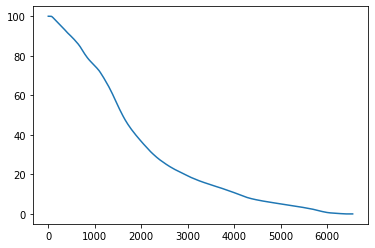

In [13]:
import matplotlib.pyplot as plt
dose = np.array(dose_content[11]['Dose [cGy]'], dtype=np.float64)
volume =  np.array(dose_content[11]['Ratio of Total Structure Volume [%]'], dtype=np.float64)
plt.plot(dose, volume)

In [ ]:
names = []
for file in files:
    row = file.split("_")
    if len(row) < 2:
        names.append([row[0], None, None])
    elif len(row) == 3:
        names.append([row[0], row[1], None])
    elif len(row) == 4:
        names.append(row[:3])
    else:
        print("error has occured in {}".format(file))